## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.utils import *

## Get Ethnicity Dataset

In [35]:
path = Path.cwd()/'ethnicity_dataset'

In [36]:
path.ls()

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset/.DS_Store'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset/chinese_men'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset/european_men'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset/models'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset/european_women'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset/chinese_women'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset/cleaned.csv')]

In [5]:
np.random.seed(2)
data = ImageDataBunch.from_folder(
    path, 
    train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(), 
    size=224,
).normalize(imagenet_stats)

In [6]:
data.classes

['chinese_men', 'chinese_women', 'european_men', 'european_women']

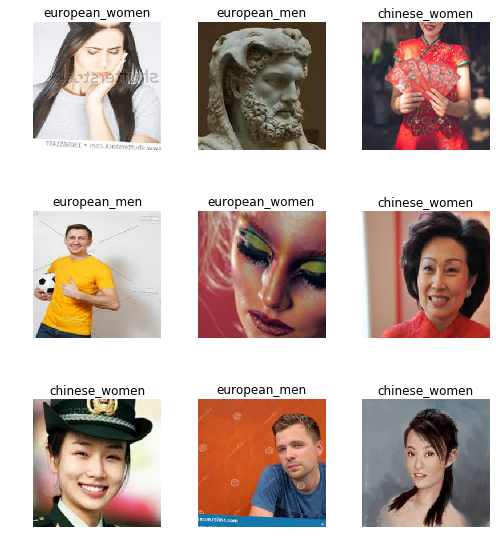

In [7]:
data.show_batch(rows=3, figsize=(7,8))

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['chinese_men', 'chinese_women', 'european_men', 'european_women'],
 4,
 551,
 137)

## Training: resnet34

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.513247,1.000068,0.437956,00:06
1,1.165895,0.829911,0.313869,00:04
2,0.981657,0.862162,0.306569,00:04
3,0.859308,0.876523,0.299270,00:04


In [11]:
learn.save('stage-1')

In [12]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


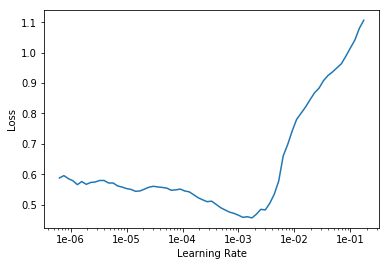

In [22]:
learn.recorder.plot()

In [13]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-04, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.583501,0.913380,0.313869,00:05
1,0.466021,0.828683,0.277372,00:04
2,0.385089,0.953627,0.270073,00:05
3,0.307547,0.885682,0.255474,00:04


In [14]:
learn.save('stage-2-34')

## Training: resnet50

In [15]:
np.random.seed(2)
data = ImageDataBunch.from_folder(
    path, 
    train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(), 
    size=299,
    bs=32,
).normalize(imagenet_stats)

In [16]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [36]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 182.00 MiB (GPU 0; 7.43 GiB total capacity; 6.75 GiB already allocated; 36.94 MiB free; 165.14 MiB cached)

In [17]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.351831,0.858311,0.299270,00:18
1,1.055253,0.808068,0.262774,00:11
2,0.841195,0.861404,0.284672,00:11
3,0.729363,0.738544,0.262774,00:11
4,0.612212,0.742308,0.270073,00:11
5,0.538964,0.790357,0.262774,00:11
6,0.458420,0.725370,0.248175,00:11
7,0.408458,0.710238,0.240876,00:11


In [18]:
learn.save('stage-1-50')

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-02, 1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,2.462699,36482478080.000000,0.839416,00:16
1,2.816052,2.645189,0.788321,00:15
2,2.539861,2.326596,0.605839,00:14


## Interpretation

In [20]:
learn.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (551 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
chinese_men,chinese_men,chinese_men,chinese_men,chinese_men
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset;

Valid: LabelList (137 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
chinese_men,chinese_women,european_women,european_women,european_men
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(


In [21]:
interp = ClassificationInterpretation.from_learner(learn)

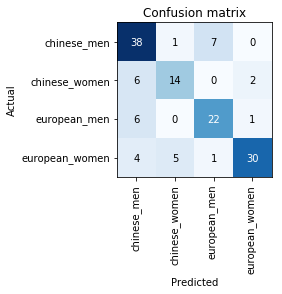

In [22]:
interp.plot_confusion_matrix()

In [23]:
interp.most_confused(min_val=3)

[('chinese_men', 'european_men', 7),
 ('chinese_women', 'chinese_men', 6),
 ('european_men', 'chinese_men', 6),
 ('european_women', 'chinese_women', 5),
 ('european_women', 'chinese_men', 4)]

## Cleaning Up

In [24]:
from fastai.widgets import *

In [26]:
db = (ImageList.from_folder(path)
                  .split_none()
                  .label_from_folder()
                  .transform(get_transforms(), size=224)
                  .databunch())

In [27]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)
learn_cln.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (688 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chinese_men,chinese_men,chinese_men,chinese_men,chinese_men
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [30]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [29]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [32]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Re-train

In [47]:
np.random.seed(2)
data = ImageDataBunch.from_csv(
    path, 
    valid_pct=0.2,
    ds_tfms=get_transforms(), 
    size=299,
    bs=32,
).normalize(imagenet_stats)

In [48]:
data.classes

['chinese_men', 'chinese_women', 'european_men', 'european_women']

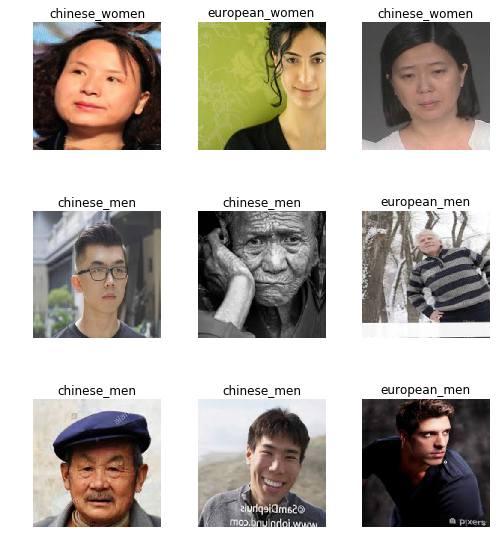

In [49]:
data.show_batch(rows=3, figsize=(7,8))

In [50]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['chinese_men', 'chinese_women', 'european_men', 'european_women'],
 4,
 543,
 135)

In [51]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


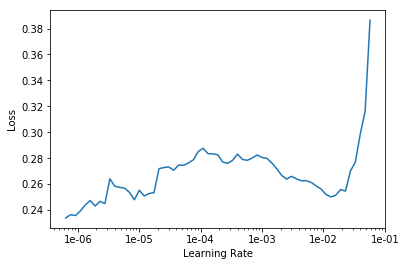

In [53]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.361473,0.955533,0.377778,00:13
1,1.074276,0.879156,0.348148,00:11
2,0.865143,0.888718,0.318519,00:11
3,0.739533,0.813421,0.288889,00:11
4,0.634314,0.780064,0.333333,00:11
5,0.533965,0.794098,0.333333,00:11
6,0.470707,0.780227,0.318519,00:11
7,0.425186,0.788059,0.333333,00:11


In [55]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,error_rate,time
0,0.947764,0.973785,0.370370,00:14
1,0.953031,0.980019,0.400000,00:14
2,0.938071,0.974835,0.392593,00:14


Why the re-trained model is not good as before? Let's just use the previous one for now.

In [56]:
learn.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (543 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
chinese_men,chinese_men,chinese_men,chinese_men,chinese_men
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset;

Valid: LabelList (135 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
european_men,european_women,european_women,chinese_women,chinese_men
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/ethnicity_dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(


## Put the model in production

In [57]:
learn.export()

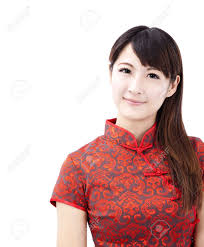

In [58]:
img = open_image(path/'chinese_women'/'images.jpeg'); img

In [59]:
learn = load_learner(path)

In [60]:
pred_class, pred_idx, outputs = learn.predict(img); pred_class

Category chinese_women

In [ ]:
learn